# City Data Hack Challenge 1 – Active Travel Planning
 

This notebook demonstrates the use of the Python recipe wrapper to create a basic data pack that you can use to get you started with the challenge of Active Travel Planning. If you want to know more on the Challenge you can visit our [Tombolo website](http://www.tombolo.org.uk/challenge-1-active-travel/). Don't forget that you can use the [City Data Explorer](https://tombolo-staging.emu-analytics.net) web app to visualise and style your results.



## Some Background

**The Tombolo project** is a Future Cities Catapult project funded by InnovateUK. It is a research and development project focused on understanding the value of data to unlock the potential of our cities. A big part of the Tombolo project is  the [Digital Connector](http://www.tombolo.org.uk/products/), an open source piece of software for Data Scientists to import and combine datasets into a standard format and model. You can visit the project on [Github](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector) to learn some background as well as instructions on how to use it.





## The goal

We will use the Python recipe implementation to tell Digital Connector to fetch some Travel related data from various sources

The geographical unit of measurement for our exports (the ***Subject*** in DC language) will be the OS Meridian 2 provided by the [OpenMapping data of Space Syntax](https://github.com/spacesyntax/OpenMapping).

The data that we will be fetching are:
* A measure of integration developed by Space Syntax representing how well integrated is the road network. Please see  [here](https://github.com/spacesyntax/OpenMapping) for more details
* Department for Transport Cycle counts
* Department for Transport Car/Taxi counts

**Please note that the above datasources are only indicative! You should think more holistic in order to tackle this challenge!**

Our output will be a GeoJson file the road network geometry along with the attributes that we specified. Feel free to play around with the code, explore the DC and download more resources that will help you tackle the Challenge! 

**<font color='red'>IMPORTANT</font>** Remember to use the TfL data available to this challenge!!!

### Lets get started

First, we import some libraries that we will be using as well as the recipe.py file
that contains all the classes necessary to build our recipes

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
%matplotlib inline
%run '/Users/fcc/Documents/digital-connector-python/recipe.py'
dc_dir = '/Documents/TomboloDigitalConnector'


# import geopandas as gpd
# import os
# from pathlib import Path
# from matplotlib import pyplot as plt

# home_dir = str(Path.home())

# %matplotlib inline
# %run os.path.join(home_dir, 'Desktop/python_library_dc/digital-connector-python/recipe.py')
# dc_dir = '/Desktop/TomboloDigitalConnector'

The first thing we need to do is to create the **Subject**. In this case our core export geometry would be the OS Meridian road network provided by Space Syntax.


In [ ]:
### recipe's subject

# Notice that we are using two more subjects here. These will serve different purposes. 
# We will use subject_la to subset the road network for the borough of Islington. We will use an intersect spatial operation
# to do that. 
subject_la = Subject(subject_type_label='localAuthority',provider_label='uk.gov.ons',
                  match_rule=Match_Rule(attribute_to_match_on="name", pattern="Islington"))

# This is our road network subject
subject = Subject(subject_type_label='space_syntax',provider_label='com.spacesyntax',
                  geo_match_rule=Geo_Match_Rule(geo_relation="intersects", subjects=[subject_la]))

subject_lsoa = Subject(subject_type_label='lsoa',provider_label='uk.gov.ons')

# subject_geometry_dft fetches the traffic counter locations represented as points
subject_geometry_dft = Subject(provider_label='uk.gov.dft',
                               subject_type_label='trafficCounter')



Next, we need to define our **Datasource**. This will tell DC what data to download. For more information on DC importers and datasource_id's consult the [catalogue.json](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector/blob/master/src/main/resources/catalogue.json) or use the terminal 

**gradle info -Pi= *name_of_the_class***

In [ ]:
### recipe's datasources

la = Datasource(importer_class='uk.org.tombolo.importer.ons.OaImporter',
                            datasource_id='localAuthority')

openmap = Datasource(importer_class='uk.org.tombolo.importer.spacesyntax.OpenMappingImporter',
                            datasource_id='SpaceSyntaxOpenMapping')

trafficCounts = Datasource(importer_class='uk.org.tombolo.importer.dft.TrafficCountImporter',
                           datasource_id='trafficCounts',
                           geography_scope = ["London"]) ## Note that geography scope is specific

Now that we defined the datasources we need to tell the DC which attributes to fetch from the database. To do that we create **AttributeMatcher** fields for all the attributes of interest. 

In [ ]:
### First, lets get our attributes

countPedalCycles_attribute = AttributeMatcher(provider='uk.gov.dft',
                                     label='CountPedalCycles')

countCarTaxis_attribute = AttributeMatcher(provider='uk.gov.dft',
                                     label='CountCarsTaxis')

integration_2km = AttributeMatcher(label='integration2km',provider='com.spacesyntax')

Having specified the attributes that we will be using, we now need to use them within DC's **Fields**. There are numerous fields each one with its own unique properties. Please consult [DC's github repo](https://github.com/FutureCitiesCatapult/TomboloDigitalConnector/blob/master/documentation/fields-and-models.md) for more information on fields.

In [42]:
### DC fields

# A very basic field that can handle numeric and time series attributes is LatestValueField. This essentially
# fetches the latest value within a time series if a time series exists. If not, it will just fetch the default value.
integration_2km_f = LatestValueField(attribute_matcher=integration_2km,
                                           label = 'Integration 2km')


count_pedal_cycles_f = LatestValueField(attribute_matcher=countCarTaxis_attribute,
                                          label='count_pedal_cycles')


count_car_taxis_f = LatestValueField(attribute_matcher=countPedalCycles_attribute,
                                          label='count_car_taxis')


# Next we need to assign the traffic counts to our subject
# As DfT traffic count geometry is points (the traffic count sensor location) we need to assign it to the nearest 
# road segment. For that we use MapToNearestSubjectField

m_count_pedal_cycles_f = MapToNearestSubjectField(field=count_pedal_cycles_f,
                                        label='Pedal traffic count',
                                        subject = subject_geometry_dft,
                                        max_radius = 1.)

m_count_car_taxis_f = MapToNearestSubjectField(field=count_car_taxis_f,
                                        label='Car/Taxi traffic count',
                                        subject = subject_geometry_dft,
                                        max_radius = 1.)
### running DC
dataset = Dataset(subjects=[subject],
                  fields=[integration_2km_f,
                          m_count_pedal_cycles_f,
                          m_count_car_taxis_f],
                  datasources=[la,
                               openmap,
                               trafficCounts])




Now we are in a good shape to run our recipe!

In [45]:
recipe = Recipe(dataset,timestamp=False)
recipe.build_recipe(console_print=False)

recipe.run_recipe(tombolo_path='/Users/fcc/Documents/TomboloDigitalConnector',
                  clear_database_cache=False,
                  output_path = 'Documents/test.json')

b':compileJava UP-TO-DATE\n'
b':processResources UP-TO-DATE\n'
b':classes UP-TO-DATE\n'
b':runExportHelp UP-TO-DATE\n'
b':runExport\n'
b'2018-03-16 16:29:27.694 [main] WARN  n.s.e.config.ConfigurationFactory - No configuration found. Configuring ehcache from ehcache-failsafe.xml  found in the classpath: jar:file:/Users/fcc/.gradle/caches/modules-2/files-2.1/net.sf.ehcache/ehcache/2.10.3/cf74f9a4a049f181833b147a1d9aa62159c9d01d/ehcache-2.10.3.jar!/ehcache-failsafe.xml\n'
b'2018-03-16 16:29:28.495 [main] INFO  uk.org.tombolo.AbstractRunner - Setting file download cache: /tmp\n'
b"2018-03-16 16:29:28.580 [main] INFO  org.ehcache.core.EhcacheManager - Cache 'fields' created in EhcacheManager.\n"
b'2018-03-16 16:29:28.715 [main] INFO  u.o.t.importer.AbstractImporter - Skipped importing uk.org.tombolo.importer.ons.OaImporter:localAuthority as this import has been completed previously\n'
b'2018-03-16 16:29:28.716 [main] INFO  u.o.t.importer.AbstractImporter - Skipped importing uk.org.tombolo.

Finally we will use geopandas to visualise and plot our export

In [46]:
gdf = gpd.read_file("/Users/fcc/Documents/test.json")
gdf.head()

,Pedal traffic count,Car/Taxi traffic count,name,label,Integration 2km,geometry
0,7565.0,728.0,1777318,com.spacesyntax_1777318,238.945027,"LINESTRING (-0.1137 51.568, -0.1127 51.5674)"
1,10449.0,894.0,1777415,com.spacesyntax_1777415,293.553534,"LINESTRING (-0.1242 51.5707, -0.1239 51.5698)"
2,21669.0,2236.0,1777416,com.spacesyntax_1777416,335.550918,"LINESTRING (-0.1238 51.5608, -0.123 51.5602)"
3,21669.0,2236.0,1777417,com.spacesyntax_1777417,349.112631,"LINESTRING (-0.1229 51.5601, -0.1218 51.5594)"
4,12035.0,1106.0,1777418,com.spacesyntax_1777418,324.093952,"LINESTRING (-0.1187 51.5637, -0.121 51.5659)"


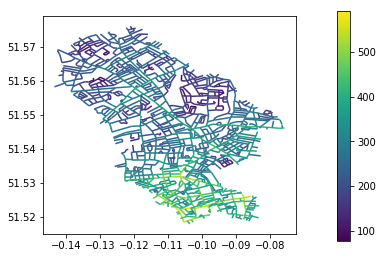

In [49]:
vmin=gdf['Integration 2km'].min()
vmax=gdf['Integration 2km'].max()
    
ax = gdf.plot(column='Integration 2km', cmap='viridis',
              vmin=vmin,
              vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

